# Calculate distances between media classes

This script was used to calculate distances between different media classes. It has been run twice: one for the immigration and one for the climate change debate. 

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import prince 

### Select debate to analyse

Here we run the cell of the debate we want to calculate the distances for

In [1]:
topic = 'IMM'
folder = '1_immigration'
title = 'Immigration Debate'

In [33]:
topic = 'CLIM'
folder = '2_climate'
title = 'Climate Debate'

In [2]:
leanings = ['left', 'centre-left', 'centre', 'centre-right', 'right']

### Initialise 

Import the datasets

In [4]:
alignment_df = pd.read_csv('/Users/giovanni/masterthesis/7_Salience_monthly/5_media_party_class_salience_CORRELATION_across_time.csv')

In [34]:
media_leanings = pd.read_csv('/Users/giovanni/masterthesis/4_Datasets/0_FR_media_leanings.csv')
edgelist = pd.read_csv(f'/Users/giovanni/masterthesis/8_Networks/3_hyphe_edgelists/{folder}/00_{topic}_dynamic_edgelist_MAIN.csv')

In [35]:
print(title)
edgelist.head()

Climate Debate


,source,target,count,source_label,target_label,timeset,time_period,start_date,end_date,monthly_period
0,36,70,2,futura-sciences.com,euronews.com,"""[1,1]""",1,2017-01-01,2017-01-15,1
1,0,15,1,francetvinfo.fr,franceinter.fr,"""[1,1]""",1,2017-01-01,2017-01-15,1
2,0,12,6,francetvinfo.fr,francebleu.fr,"""[1,1]""",1,2017-01-01,2017-01-15,1
3,0,45,2,francetvinfo.fr,bienpublic.com,"""[1,1]""",1,2017-01-01,2017-01-15,1
4,0,19,1,francetvinfo.fr,franceculture.fr,"""[1,1]""",1,2017-01-01,2017-01-15,1


### Define functions

In [7]:
def euclidean_distance(vector1, vector2):
    array1 = np.array(vector1)
    array2 = np.array(vector2)

    distance = np.linalg.norm(array1 - array2)

    return distance

def calculate_domain_distance(ca,contingency_table, domain1, domain2):
    row_coordinates_df = ca.row_coordinates(contingency_table)

    vector_a = row_coordinates_df[row_coordinates_df.index == domain1]
    vector_b = row_coordinates_df[row_coordinates_df.index == domain2]

    return euclidean_distance(vector_a, vector_b)


def calculate_distance(row, ca, contingency_table):
    domain1 = row['domain1']
    domain2 = row['domain2']
    return calculate_domain_distance(ca, contingency_table, domain1, domain2)

def calculate_avg_distance(df, domain1_parameter, domain2_parameter):
    different_classes = df[df[domain1_parameter] != df[domain2_parameter]]
    avg_distance = different_classes.groupby([domain1_parameter, domain2_parameter])['distance'].mean().unstack()
    return avg_distance

In [8]:
def calculate_distances_per_timeperiod():    
    df = None
    df = pd.DataFrame(columns = ['domain1_leaning', 'domain2_leaning', 'network_distance', 'timeperiod',
       'start_date', 'end_date'])
    
    timeperiods = list(range(1, 69))
    
    for timeperiod in timeperiods:
        # subset time period
        temp = edgelist[edgelist['time_period'] == timeperiod]
        temp.reset_index(drop=True, inplace = True)

        #create contingency table
        contingency_table = pd.crosstab(index=temp['source_label'],
                                        columns=temp['target_label'],
                                        values=temp['count'],
                                        aggfunc='sum')
        contingency_table.fillna(0,inplace=True)

        # create network embedding for time period
        ca = prince.CA(n_components=2,n_iter=10,copy=True,check_input=True,engine='sklearn',random_state=42)
        ca = ca.fit(contingency_table)

        # Calculate distances using vectorized apply
        distance_df = pd.DataFrame(np.array(np.meshgrid(temp['source_label'], temp['target_label'])).T.reshape(-1, 2), columns=['domain1', 'domain2'])
        distance_df['distance'] = distance_df.apply(calculate_distance, axis=1, ca=ca, contingency_table=contingency_table)


        distance_df["domain1_leaning"] = distance_df["domain1"].map(media_leanings.set_index("domain")["leaning"])
        distance_df["domain2_leaning"] = distance_df["domain2"].map(media_leanings.set_index("domain")["leaning"])
        
        avg_distance = calculate_avg_distance(distance_df, domain1_parameter="domain1_leaning", domain2_parameter="domain2_leaning")
        avg_distance = avg_distance.reindex(index=['left', 'centre-left', 'centre', 'centre-right', 'right'], 
                                    columns=['left', 'centre-left', 'centre', 'centre-right', 'right'])
        
        avg_distance.reset_index(inplace=True)  # Reset index to make 'domain1_leaning' a column
        melted_df = avg_distance.melt(id_vars='domain1_leaning', var_name='domain2_leaning', value_name=f'network_distance_{topic}')
        melted_df.dropna(inplace=True)
        
        melted_df['timeperiod'] = timeperiod
        melted_df['start_date'] = temp.loc[0, 'start_date']
        melted_df['end_date'] = temp.loc[0, 'end_date']
        
        df = pd.concat([df, melted_df], ignore_index = True)
        
    return df
    

### Apply the functions

In [36]:
df = calculate_distances_per_timeperiod()

In [38]:
df.to_csv(f'/Users/giovanni/masterthesis/9_Analysis/1_{topic}_media_class_distances_across_time_monthly.csv', index = False)

Map salience alignment between the two classes.

In [14]:
df1 = df.copy()

df1['imm_alignment_party_media'] = df1.apply(lambda row: alignment_df[
            (alignment_df['media_leaning'] == row['domain1_leaning']) &
    (alignment_df['party_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
]['imm_alignment'].values[0] if not alignment_df[
            (alignment_df['media_leaning'] == row['domain1_leaning']) &
    (alignment_df['party_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
].empty else 0, axis=1)

df1['imm_alignment_media_party'] = df1.apply(lambda row: alignment_df[
            (alignment_df['party_leaning'] == row['domain1_leaning']) &
    (alignment_df['media_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
]['imm_alignment'].values[0] if not alignment_df[
            (alignment_df['party_leaning'] == row['domain1_leaning']) &
    (alignment_df['media_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
].empty else 0, axis=1)


df1 = df1[df1['network_distance_IMM'] != 0]
df1 = df1[df1['imm_alignment_media_party'] != 0]
df1 = df1[df1['imm_alignment_party_media'] != 0]

In [39]:
df1 = df.copy()

df1['clim_alignment_party_media'] = df1.apply(lambda row: alignment_df[
            (alignment_df['media_leaning'] == row['domain1_leaning']) &
    (alignment_df['party_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
]['clim_alignment'].values[0] if not alignment_df[
            (alignment_df['media_leaning'] == row['domain1_leaning']) &
    (alignment_df['party_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
].empty else 0, axis=1)

df1['clim_alignment_media_party'] = df1.apply(lambda row: alignment_df[
            (alignment_df['party_leaning'] == row['domain1_leaning']) &
    (alignment_df['media_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
]['clim_alignment'].values[0] if not alignment_df[
            (alignment_df['party_leaning'] == row['domain1_leaning']) &
    (alignment_df['media_leaning'] == row['domain2_leaning']) &
    (alignment_df['time_period'] == row['timeperiod'])
].empty else 0, axis=1)


df1 = df1[df1['network_distance_CLIM'] != 0]
df1 = df1[df1['clim_alignment_media_party'] != 0]
df1 = df1[df1['clim_alignment_party_media'] != 0]

In [40]:
df1

,domain1_leaning,domain2_leaning,network_distance,timeperiod,start_date,end_date,network_distance_CLIM,clim_alignment_party_media,clim_alignment_media_party
22,left,centre,NaN,2,2017-01-15,2017-01-29,1.628617,0.000701,0.000253
51,left,centre-right,NaN,4,2017-02-12,2017-02-26,4.995143,0.000107,0.000056
57,centre,left,NaN,5,2017-02-26,2017-03-12,0.180877,0.000109,0.000200
62,left,centre,NaN,5,2017-02-26,2017-03-12,0.488107,0.000200,0.000109
73,centre,left,NaN,6,2017-03-12,2017-03-26,0.434734,0.000526,0.000306
...,...,...,...,...,...,...,...,...,...
523,centre-left,centre,NaN,32,2018-03-11,2018-03-25,1.561560,0.003133,0.002578
524,centre-right,centre,NaN,32,2018-03-11,2018-03-25,1.277407,0.001776,0.002578
525,left,centre-right,NaN,32,2018-03-11,2018-03-25,1.701449,0.004022,0.002105
526,centre-left,centre-right,NaN,32,2018-03-11,2018-03-25,1.787489,0.005073,0.002875


In [41]:
df1.to_csv(f'/Users/giovanni/masterthesis/9_Analysis/2_{topic}_network_salience_class_comparison_across_time_no_zeros.csv', index = False)

## Exploratory plots of the relationship between the IV and DV

In [54]:
def plot(data, x, y, x_max, y_max):
    temp = data.copy()
    
    
    color_map = {'left':'red',
         'centre-left':'purple',
         'centre':'blue',
         'centre-right':'lightseagreen',#'darkcyan',#lightseagreen
         'right': 'green'}

    temp['color'] = temp['domain1_leaning'].map(color_map)
    
    
    x_values = temp[x]
    y_values = temp[y]
    colors = temp['color']

    plt.figure(figsize=(4, 8)) 
    
    plt.scatter(x_values, y_values, color=colors)
    
    for label, color in color_map.items():
        plt.scatter([], [], color=color, label=label)
    
    plt.title(f'Salience alignment and outlets distance – {title}')
    plt.xlabel(x)
    plt.ylabel(f'{y}')
    plt.ylim(0, y_max)
    plt.xlim(0, x_max)
    plt.grid(True)
    plt.legend()
    
    slope, intercept = np.polyfit(x_values, y_values, 1)
    plt.plot(x_values, slope*x_values + intercept, color='red')

    plt.show()

## Immigration

In [51]:
max_alignment = max(imm_df['imm_alignment_media_party'])
max_distance = max(imm_df['network_distance_IMM'])

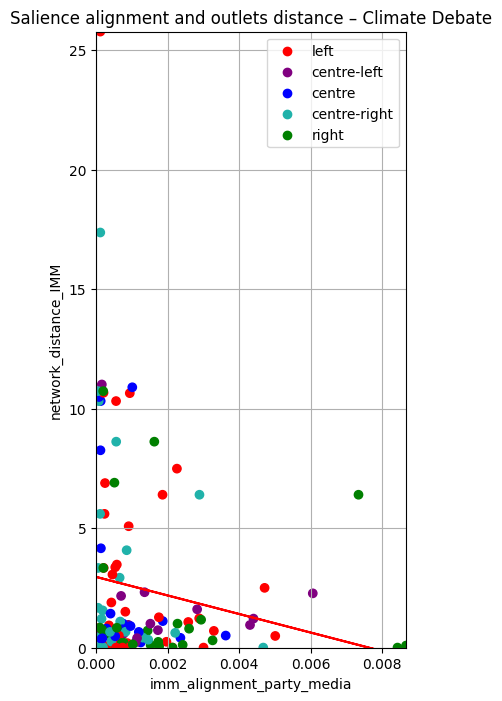

In [55]:
plot(imm_df,'imm_alignment_party_media','network_distance_IMM', max_alignment, max_distance)

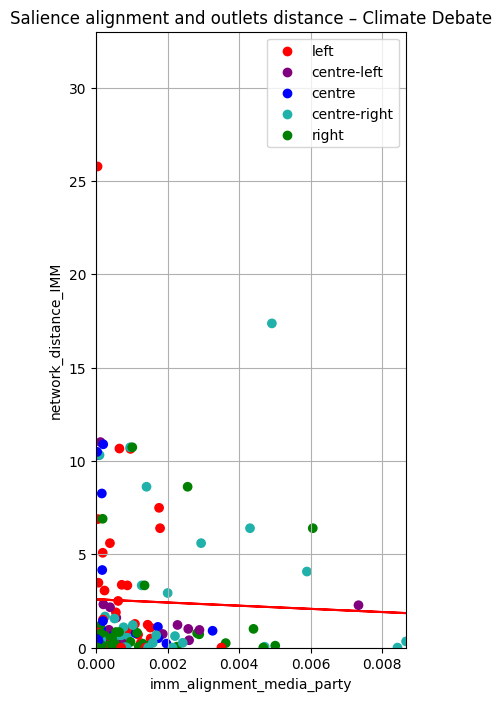

In [56]:
plot(imm_df,'imm_alignment_media_party','network_distance_IMM', max_alignment,
     33)

## Climate

In [57]:
max_alignment = max(clim_df['clim_alignment_media_party'])
max_distance = max(clim_df['network_distance_CLIM'])

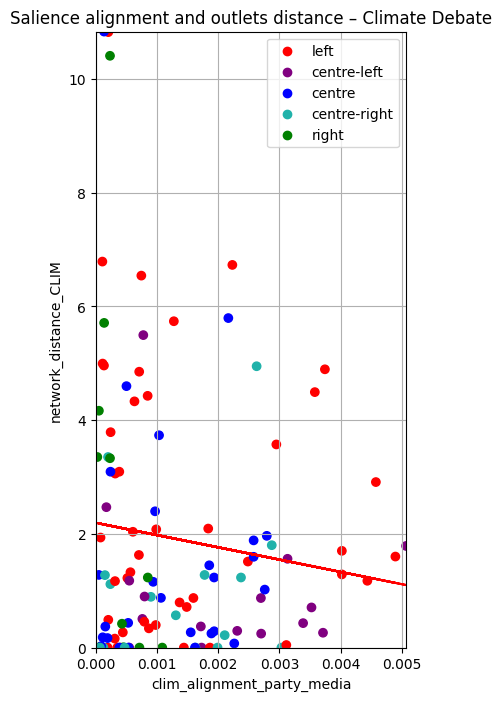

In [59]:
plot(clim_df,'clim_alignment_party_media','network_distance_CLIM', max_alignment, max_distance)

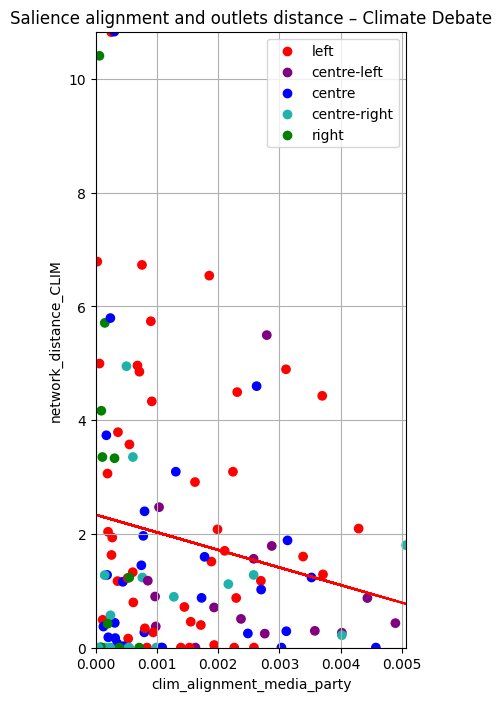

In [61]:
plot(clim_df,'clim_alignment_media_party','network_distance_CLIM', max_alignment, max_distance)

# Match only for one leaning

## CLIMATE

### Right

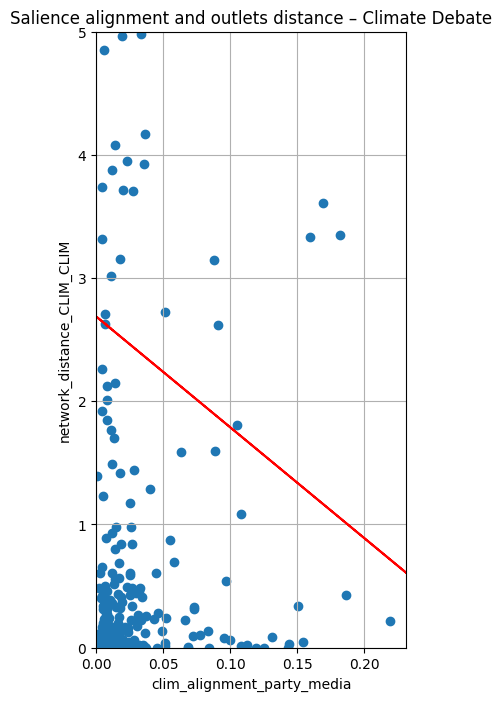

In [219]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'right'], df1[df1['domain2_leaning'] == 'right']], ignore_index = True)
plot(df_lean,'clim_alignment_party_media','network_distance_CLIM', max_alignment,
     max_distance +5)


### Left

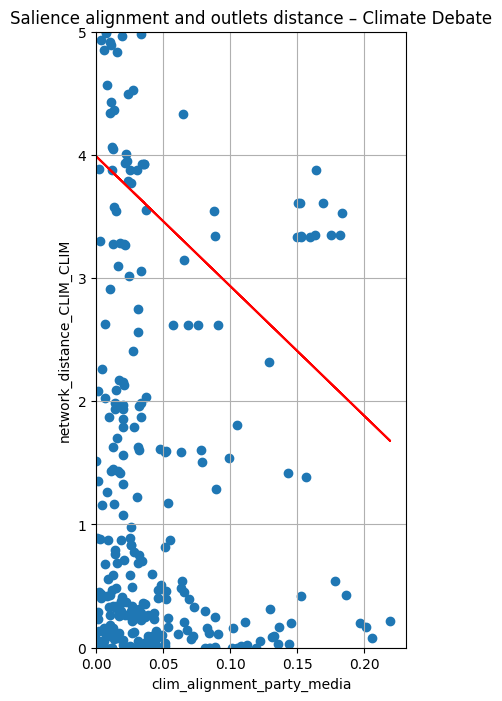

In [220]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'left'], df1[df1['domain2_leaning'] == 'left']], ignore_index = True)
plot(df_lean,'clim_alignment_party_media','network_distance_CLIM', max_alignment,
     max_distance +5)

### Centre


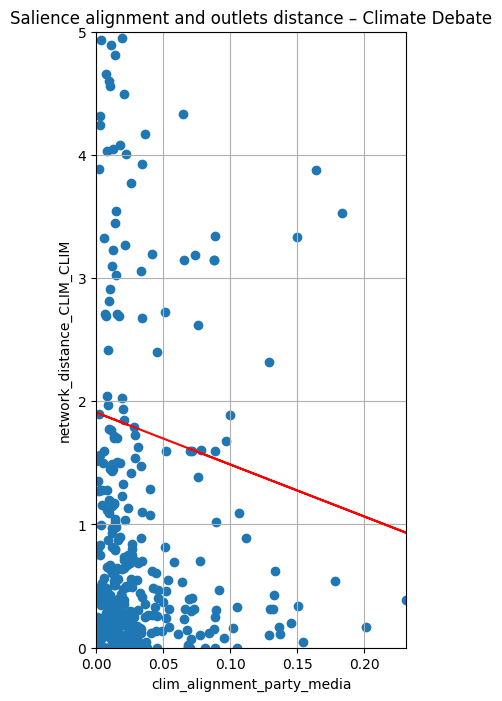

In [221]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'centre'], df1[df1['domain2_leaning'] == 'centre']], ignore_index = True)
plot(df_lean,'clim_alignment_party_media','network_distance_CLIM', max_alignment,
     max_distance +5)



### Centre-right

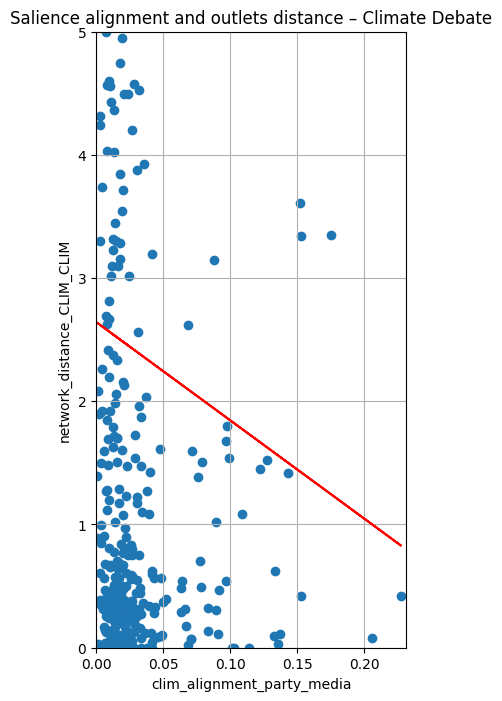

In [222]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'centre-right'], df1[df1['domain2_leaning'] == 'centre-right']], ignore_index = True)
plot(df_lean,'clim_alignment_party_media','network_distance_CLIM', max_alignment,
     max_distance +5)



### Centre-left

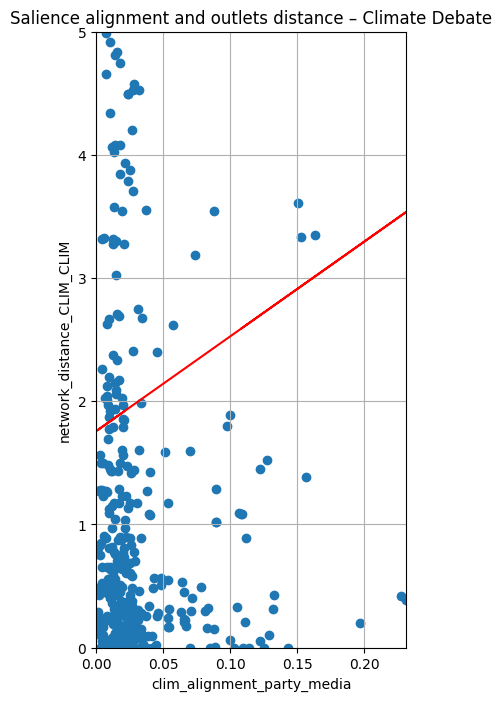

In [223]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'centre-left'], df1[df1['domain2_leaning'] == 'centre-left']], ignore_index = True)
plot(df_lean,'clim_alignment_party_media','network_distance_CLIM', max_alignment,
     max_distance +5)


## IMMIGRATION

### Right

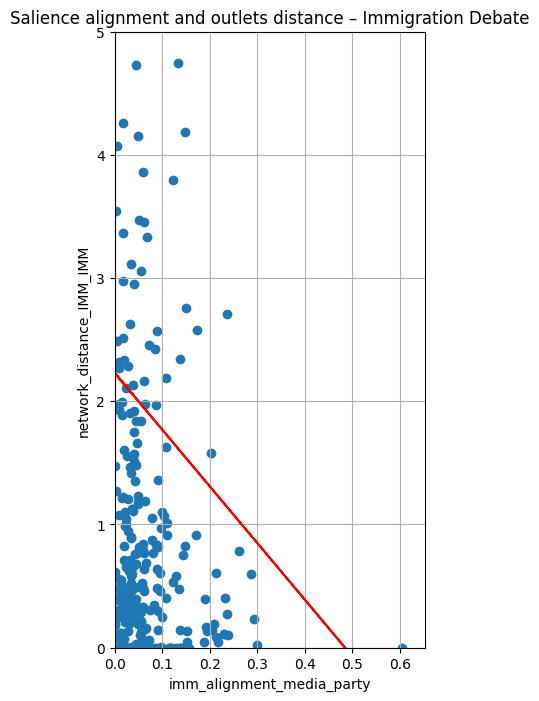

In [243]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'right'], df1[df1['domain2_leaning'] == 'right']], ignore_index = True)
plot(df_lean,'imm_alignment_media_party','network_distance_IMM', max_alignment, max_distance)

### Left

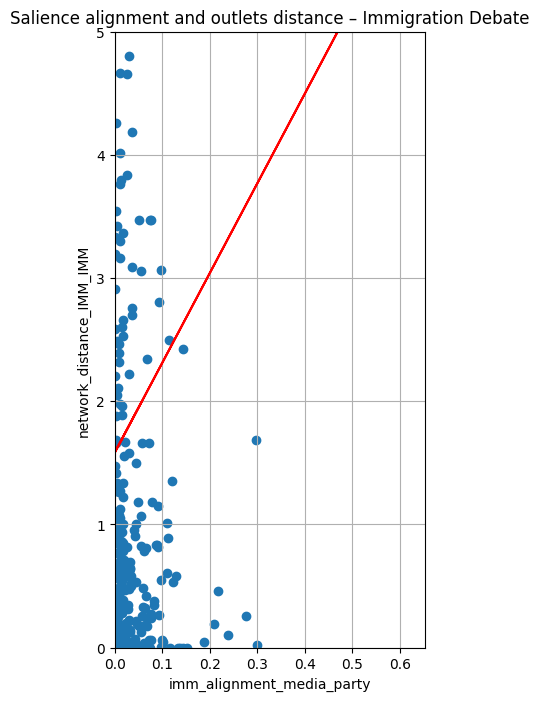

In [244]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'left'], df1[df1['domain2_leaning'] == 'left']], ignore_index = True)
plot(df_lean,'imm_alignment_media_party','network_distance_IMM', max_alignment, max_distance)

### Centre

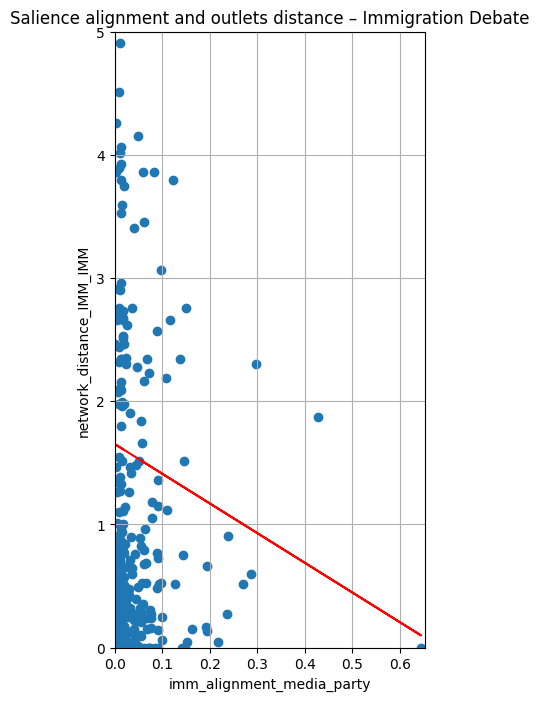

In [245]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'centre'], df1[df1['domain2_leaning'] == 'centre']], ignore_index = True)
plot(df_lean,'imm_alignment_media_party','network_distance_IMM', max_alignment, max_distance)

### Centre-right

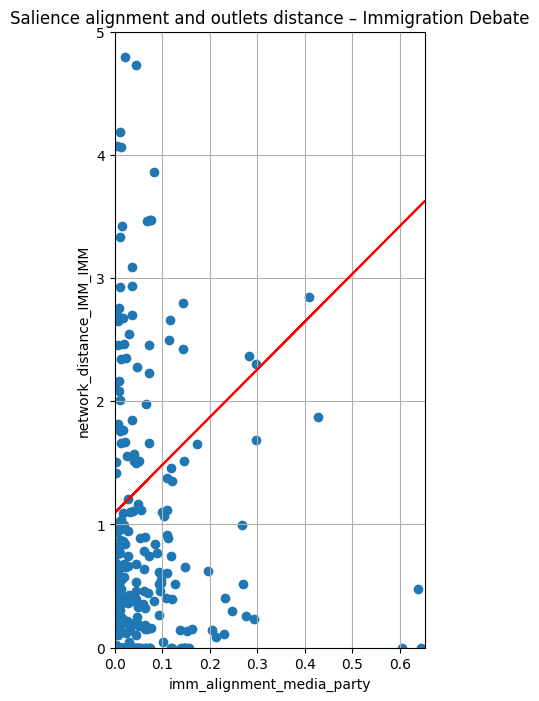

In [246]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'centre-right'], df1[df1['domain2_leaning'] == 'centre-right']], ignore_index = True)
plot(df_lean,'imm_alignment_media_party','network_distance_IMM', max_alignment, max_distance)

### Centre-left

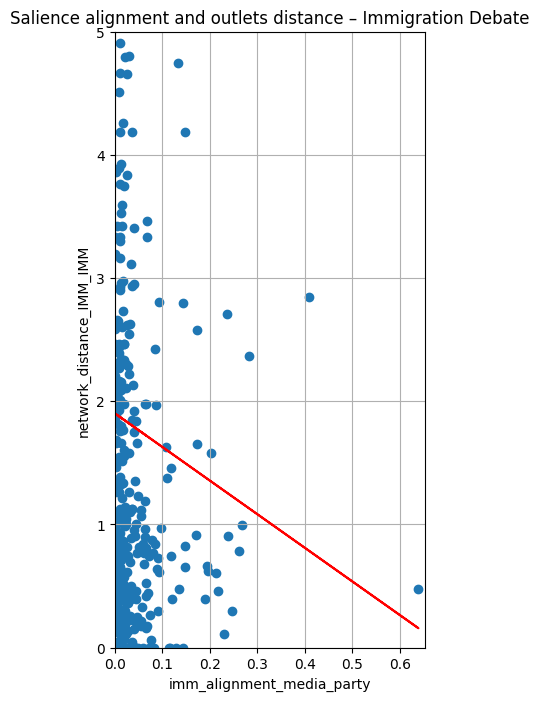

In [247]:
df_lean = pd.concat([df1[df1['domain1_leaning'] == 'centre-left'], df1[df1['domain2_leaning'] == 'centre-left']], ignore_index = True)
plot(df_lean,'imm_alignment_media_party','network_distance_IMM', max_alignment, max_distance)